# Define Arduino-Like Functions
Import all the usual stuff, then define some functions that we can use to practice our thinking about the Arduino model without needing the hardware. You don't need to know all the details in this code -- just run it to enable the capabilities we will use below.

Nothing can replace the real hardware. A real UNO will have slightly different timing behaviour than this simulation, for example.

The various analogRead outputs resemble things you might measure in some of the MECH 217 labs, so we can use these signals to test our ideas before we get there.

In [1]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)

from datetime import *

t0Arduino = datetime.now()  # the time the simulated Arduino started running
A0 = 14                     # the pin numbers of each of the analog inputs on the UNO
A1 = 15
A2 = 16
A3 = 17
A4 = 18
A5 = 19

#some functions that do the same thing as these macros we defined
#define P Serial.print
#define PCS Serial.print(", ");Serial.print
#define PCSL Serial.print(", ");Serial.println
def P(x):
    print(x, end='', flush=True) # no space or end of line
def PCS(x):
    print(", ", end='', flush=True)
    print(x, end='', flush=True)
def PCSL(x):
    print(", ", end='', flush=True)
    print(x)
    
def setup():                # these need to be defined in your sketch cell
    print('in dummy setup')
def loop():
    print('in dummy loop')
    
def micros():               # microseconds since time was reset
    dt = datetime.now()-t0Arduino
    return dt.microseconds + dt.seconds * 1000000 

def delay(t):               # pause for t milliseconds
    tn = t0 = micros()
    while((tn-t0)/1000 <= t):
        tn = micros()
    
def delayMicroseconds(t):   # pause for t microseconds
    tn = t0 = micros()
    while((tn-t0) <= t):
        tn = micros()

def resetArduinoTime(): # run Arduino sketch cell code for t seconds
    global t0Arduino
    t0Arduino = datetime.now()    # restart the micros() clock

def runArduino(t = 300): # run Arduino sketch cell code for t seconds
    resetArduinoTime()
    setup()                       # run setup() once
    delay(1)
    while(micros() < t*1000000):  # until time runs out
        loop()                    # keep running loop() over and over
        delay(1)
    

PSEUDO_GROUND=   1.239
USB_VOLTAGE=     5.043
V33=             3.296
V11=             1.086

VrefX = USB_VOLTAGE

def analogRead(port,delay = 100):        #// a substitute for analogRead()
#   // Returns data as if there were various circuits attached to the Arduino
#   // with predefined events corresponding to some of the MECH 217 lab activities.
    t = micros()
    ts = t /1000000. #// time in seconds
    A = 0              #// so it can go a little negative and round back up to 0
    V = 0            #// voltage on the pin in volts
    if (port == A0):
        V = VTMP36(ts)#; // a TMP36 on a coffee cup, water poured at 10 seconds
    elif(port == A1):
        V = Vpot(ts)#;   // a potentiometer being turned manually through 180 degrees
    elif(port == A2):
        V = Vacc(ts)#;  // an accelerometer being held flat, then on each edge, then moving
    elif(port == A3):
        V = Vload(ts)#; // a load cell subject to increasing loads, then step loads
    elif(port == A4):
        V = Vpseudo(ts)#;  // the voltage of the amplifier pseudo-ground
    elif(port == A5):
        #V = sin(ts)*0.50 + 4.5; // a sin wave in case you need one
        V = Vtc(ts);
    else: V = 0
    A = int(1023 * V/VrefX + random.randn()*0.75)#;   // conversion bit variation
    A = min(1023,A)#;                                 // force into range
    A = max(0,A)
    delayMicroseconds(delay)  # Slow it down to reflect real time required fro Arduino ADC
    return A

def Vpseudo(ts):#{  // the voltage of the amplifier pseudo-ground
    return PSEUDO_GROUND + random.randn()*0.005

def VTMP36(ts, tc1 = 15, tc2 = 20): #{   // a TMP36 on a coffee cup, water poured at 10 seconds
    Ta = 22.
    Tc = 80.
    Ts = Ta
    tsu = int(ts)
    tw = ts - int(tsu/120)*120 - 10                # repeat every two minutes
    if(tw < 0): Ts = Ta                            # initially at ambient
    elif(tw < 60): Ts = Tc - exp(-tw/tc1)*(Tc-Ta)   # decay towards cup T
    else: Ts = Ta - exp(-(tw-60)/tc2)*(Ta-Tc)       # decay back to ambient
    return Ts * 0.010 + 0.5 + random.randn()*0.005 # voltage with 10mV noise

def Vtc(ts):
    return VTMP36(ts,tc1 = 4,tc2 = 8)

def Vpot(ts):     #{    // a potentiometer being turned manually through 180 degrees
    tw = ts - int(ts/20)*20 # repeat every 20 seconds
    if(tw < 3.1416): V = 0.8
    elif(tw < 2 * 3.1416): V = 0.8 + 1.50 * (cos(tw) + 1)
    elif(tw < 3 * 3.1416): V = 3.8
    elif(tw < 5 * 3.1416): V = 2.3 - 1.5 * sin(0.5*tw)
    else: V = 0.8
    return V + random.randn()*0.005;

def Vload(ts): #{     // a load cell subject to increasing loads, then step loads
    tsu = int(ts)
    tw = ts - int(tsu/60)*60                    # repeat every minute
    if(tw < 10): m = (tsu%60)/2                 # 0, 1, 2, 3, 4 kg
    elif(tw < 12): m = 1.5                      # back to 1.5, then jump to 2.5, 4.5, 0
    # frequency prop to m**-0.5, tau prop to m
    elif(tw < 25): m = 2.5 - exp(-(tw-12)/2.5)*cos((tw-12)*3.1416 *10/sqrt(2.5))
    elif(tw < 45): m = 4.5 - 2 * exp(-(tw-25)/4.5)*cos((tw-25)*3.1416 *10/sqrt(4.5))
    else: m = 0 - 4.5 * exp(-(tw-45)/.1)*cos((tw-45)*3.1416 *10/sqrt(.1))
    m += random.randn()*0.02
    return 1.24 + m * 0.287 + random.randn() * 0.005

def Vacc(ts):  #{   // an accelerometer being held flat, then on each edge, then moving
    tsu = int(ts)
    tw = ts - int(tsu/60)*60                         # repeat every minute
    if(tw < 5): m = 0
    elif(tw < 10): m = 1.0
    elif(tw < 15): m = -1.0
    elif(tw < 25): m = 0
    elif(tw < 35): m = 0.8 * sqrt(max(0,sin((tw-25)/10 * 3.1416)))*sin((tw-25)*3.1416)
    elif(tw < 40): m = 0
    elif(tw < 45): m = 2.8 * sqrt(sqrt(max(0,sin((tw-40)/5 * 3.1416))))*sin((tw-40)*5*3.1416)
    else: m = 0
    m += random.randn()*0.004
    return 1.57 + m * 0.487 + random.randn() * 0.005;



## Take some data and print it out
This is very similar to the code we would write for the Arduino, to read data from two analog inputs and print it out occasionally to see the results.


In [2]:
lastPrint = 0

def setup():
    # Serial.begin(115200); // not needed in the python version
    P("In the setup() function")
    P("\n")

def loop():
    global lastPrint          # use the global version
    tNowS = micros()/1000000  # read the time
    d0 = analogRead(A0)       # read an analog value
    d1 = analogRead(A1)       # read an analog value
    
    if(micros() - lastPrint > 1000000):  # don't print very often
        lastPrint = micros()             # update the last time you printed
        P(tNowS)                         # print stuff out
        PCS(d0)
        PCSL(d1)

        
runArduino(10) # run the Arduino sketch for a while


In the setup() function
0.999985, 147, 162
2.000715, 143, 162
3.001493, 145, 161
4.002691, 146, 265
5.00332, 144, 553
6.004133, 148, 758
7.004346, 146, 771
8.005375, 146, 770
9.006091, 142, 768


## Display the signals we can read with the Arduino
This cell will take quite a long time to run, but will eventually generate a graph of the way the various analog channels change over time. Part of the reason it takes so long is the delay we put in the simulated analogRead() function to intentionally slow down the whole process to be closer to the Arduino processing speed scale. The other part is that we made the signals change relatively slowly over time, so we have to wait for all of these changes to take place in real time. Your code will be much simpler!

In the setup() function
4.999397, 146.0, 552.0, 318.0, 369.0, 250.0, 144.0
10.000665, 145.0, 758.0, 222.0, 337.0, 250.0, 146.0
15.001235, 178.0, 180.0, 318.0, 411.0, 252.0, 230.0
20.002133, 203.0, 162.0, 320.0, 398.0, 251.0, 255.0
25.002579, 220.0, 553.0, 318.0, 396.0, 251.0, 260.0
30.004212, 231.0, 758.0, 319.0, 500.0, 250.0, 263.0
35.004753, 241.0, 181.0, 318.0, 525.0, 252.0, 263.0
40.005804, 247.0, 163.0, 325.0, 513.0, 250.0, 264.0
45.005116, 251.0, 553.0, 318.0, 82.0, 251.0, 262.0
50.009776, 257.0, 759.0, 318.0, 252.0, 248.0, 262.0
55.009774, 257.0, 180.0, 318.0, 252.0, 252.0, 262.0
60.011431, 262.0, 160.0, 318.0, 250.0, 250.0, 264.0
65.012418, 259.0, 557.0, 418.0, 398.0, 254.0, 264.0


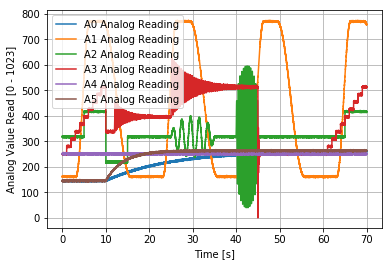

In [3]:
watchFor = 70                  # rough number of seconds to watch the data
# more than number of iterations reading all six channels at about 10000 Hz
n = int(10000 * watchFor / 6)
d = zeros((n,7))              # a large space to keep the data
cnt = 0                       # total number of iterations completed

lastPrint = 0

def setup():
    # Serial.begin(115200); // not needed in the python version
    P("In the setup() function")
    P("\n")

def loop():
    global lastPrint,d,cnt
    tNowS = micros()/1000000

    d[cnt,0] = tNowS          # this bit is just for the graph and too huge for Arduino
    for j in range(0,6):
        d[cnt,j+1] = analogRead(A0+j)
    
    if(micros() - lastPrint > 5000000):
        lastPrint = micros()
        P(d[cnt,0])
        for j in range(0,6): PCS(d[cnt,j+1])
        P("\n")
    cnt = cnt + 1
    
runArduino(watchFor)

for j in range(0,6):
    plot(d[:cnt,0],d[:cnt,j+1],label="A%d Analog Reading"%j)
grid()
legend()
xlabel("Time [s]")
ylabel("Analog Value Read [0 - 1023]")

savetxt("analogRead.csv", d[:cnt], delimiter=",")   # write the CSV file
